In [1]:
descat='des.tsv' # use https://vizier.u-strasbg.fr/viz-bin/VizieR?-source=II/357, select XML+CSV output type in left bar; remove pre-amble and post-amble by hand
grbcat='test.cat'
cutoutcat='cutout1.cat'
coadd='coadd.fits'
ra=309.04816
dec=-44.440262
pixel_size=0.2637

In [2]:
# ascii reading
from astropy.io import ascii
import pandas as pd

# Catalog matching
from astropy.coordinates import SkyCoord
from astropy import units as u

# from datavis.ascii.match_catalogs import find_closest_in_cat

def match_catalogs_df(df_ref, df_sci,radius_threshold=2 * u.arcsec,
               ref_RA_KEY='X_WORLD',ref_DEC_KEY='Y_WORLD',
               sci_RA_KEY='X_WORLD',sci_DEC_KEY='Y_WORLD',
               find_close=True, reindex=True):
    '''Input pandas data frame object for ref and sci catalogs, output pandas DataFrame of 
    matched ref catalog entries and matched sci catalog entries. All columns in inputs are preserved.
    '''
    coords_ref = SkyCoord(ra=df_ref[ref_RA_KEY], dec=df_ref[ref_DEC_KEY],unit='deg')
    coords_sci = SkyCoord(ra=df_sci[sci_RA_KEY], dec=df_sci[sci_DEC_KEY],unit='deg')
    
    # index = nearest in csci that matches cref
    # index = for each cref, get nearest csci
    # len(idx) = len(df_ref)
    idx, d2d, d3d = coords_ref.match_to_catalog_3d(coords_sci)
    
    # Sep constraint
    if find_close:
        sep_constraint = d2d <= radius_threshold
    else:
        sep_constraint = d2d > radius_threshold

    # Get entries in cat_ref with a match
    df_ref_matched = df_ref[sep_constraint]
    
    # Get matched entries in cat_sci
    df_sci_matched = df_sci.iloc[idx[sep_constraint]]

    # re-index to match two dfs
    if reindex:
        df_ref_matched_reindex=df_ref_matched.reset_index()
        df_sci_matched_reindex=df_sci_matched.reset_index()
        return df_ref_matched_reindex, df_sci_matched_reindex
    else:
        return df_ref_matched, df_sci_matched

def find_closest_in_cat(df_sci,RA,DEC,radius_threshold=2 * u.arcsec,
               sci_RA_KEY='X_WORLD',sci_DEC_KEY='Y_WORLD'):
    '''Input pandas DataFrame catalog, output line in DataFrame closest in input RA,DEC. 
    All columns in inputs are preserved.
    '''
    try:
        x=len(RA)
        coords_ref = SkyCoord(ra=RA, dec=DEC,unit='deg')
    except:
        coords_ref = SkyCoord(ra=[RA], dec=[DEC],unit='deg')
    coords_sci = SkyCoord(ra=df_sci[sci_RA_KEY], dec=df_sci[sci_DEC_KEY],unit='deg')
    
    # index = nearest in csci that matches input RA,DEC
    # index = for each input RA, DEC, get nearest csci
    # len(idx) = len(RA)
    idx, d2d, d3d = coords_ref.match_to_catalog_3d(coords_sci)
    
    # Sep constraint
    sep_constraint = d2d < radius_threshold
    
    # Get matched entries in cat_sci
    df_sci_matched = df_sci.iloc[idx[sep_constraint]]
    
    return df_sci_matched,d2d


In [3]:
"""create_cutouts.py - Create cutouts based on max, min RA and max, min dec or Centre RA/DEC and radius. Cutout fits file will have the right wcs information. 
Usage:
    create_cutouts [-h] [-v] [-d] [--corners STRING] [--centre STRING] [--radius STRING] [-o DIRECTORY] <image>...
Options:
    -h, --help                  Show this screen [default: False]
    -v, --verbose               Show extra information [default: False]
    -d, --debug                 Show debugging information [default: False]
    --corners STRING            Cutout's min RA, max RA, min DEC, max DEC e.g. 20.0,31.0,-28,-24
    --centre STRING             Cutout's central RA, DEC e.g. 34.3,-30.0
    --radius STRING             Cutout's radius if -C. e.g. 3,arcmin or 30,arcsec or 1,deg
    -o DIRECTORY, --outdir DIRECTORY    Output directory where cutout images are saved [default: .]
"""

import astropy.io.fits as fits
import os
import ntpath
from pathlib import Path
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from astropy.visualization import LinearStretch
from astropy.visualization import ZScaleInterval
from astropy.visualization import ImageNormalize

def imshow_zscale(image,fits=False,grid=True,ticks=False):
    if fits==True:
        d = fits.getdata(image)
    else:
        d=image
    norm = ImageNormalize(d, interval=ZScaleInterval(),stretch=LinearStretch())
    plt.imshow(d, cmap=plt.cm.gray, norm=norm, interpolation='none')
    if ticks:
        plt.tick_params(labelsize=16)
    if grid:
        plt.grid()
    return None

def create_cutout_centre(fitsfile,RA,DEC,image_size,verbose=False,debug=False):
    # Read data
    d,h = fits.getdata(fitsfile,header=True)
    w = WCS(h)
    # Get position in SkyCoords
    pos = SkyCoord(RA, DEC, unit=u.deg)
    # Create cutout
    cutout = Cutout2D(d, size=image_size, position=pos, wcs=w)
    # Create new cutout header with right WCS
    h.update(cutout.wcs.to_header())
    return cutout.data, h




In [4]:
import astropy.io.ascii as ascii
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
import numpy as np
import astropy.io.fits as fits

# Zeropoint

Next run source extractor on the fits file and then use the cat file for the following:

In [5]:
d_grb=ascii.read(grbcat)
d_des=ascii.read(descat,delimiter=';',exclude_names='DES')

# df grb image cat
df_grb=pd.DataFrame(d_grb.as_array())
df_grb_select=df_grb[( (df_grb['ELLIPTICITY']<0.7) &  (df_grb['FLAGS']==0)   & (df_grb['MAG_AUTO']>-14) &
                       (df_grb['Y_WORLD']<-44.39) &  (df_grb['Y_WORLD']>-44.49) &
                       (df_grb['X_WORLD']>308.97) &  (df_grb['X_WORLD']<309.12)
                      )]
print(len(df_grb),len(df_grb_select))

# df des cat
dic_des = {}
dic_des['RA']=d_des['RAJ2000']
dic_des['DEC']=d_des['DEJ2000']
dic_des['sg_g']=d_des['S/Gg']
dic_des['sg_r']=d_des['S/Gr']
dic_des['sg_i']=d_des['S/Gi']
dic_des['sg_z']=d_des['S/Gz']
dic_des['sg_Y']=d_des['S/GY']
dic_des['gmag']=d_des['gmag']
dic_des['rmag']=d_des['rmag']
dic_des['imag']=d_des['imag']
dic_des['zmag']=d_des['zmag']
dic_des['Ymag']=d_des['Ymag']
dic_des['iFlag']=d_des['iFlag']
dic_des['e_imag']=d_des['e_imag']
df_des = pd.DataFrame(dic_des)
df_des_select = df_des[ ((df_des['imag']<20) &  (df_des['iFlag']==0)  & (df_des['e_imag']<0.1) ) ]
print(len(df_des),len(df_des_select))

3617 672
939 94


In [6]:
np.average(df_grb_select['FWHM_IMAGE'])*pixel_size #snese of a full width half max

1.6885433035714283

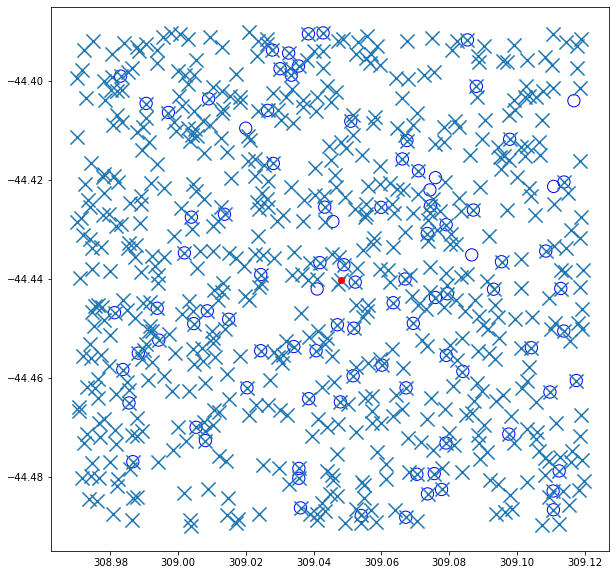

In [7]:
plt.figure(figsize=(10,10))
plt.scatter(df_des_select['RA'],df_des_select['DEC'],marker='o',facecolors='none', edgecolors='b',s=150) #reference 
plt.scatter(df_grb_select['X_WORLD'],df_grb_select['Y_WORLD'],marker='x',s=200) #your data
plt.scatter(ra,dec,color='r') #centre red dot 

In [8]:
df_grb_matched_reindex,df_des_matched_reindex = match_catalogs_df(df_grb_select, df_des_select,radius_threshold=1.0 * u.arcsec,
                                                   ref_RA_KEY='X_WORLD',ref_DEC_KEY='Y_WORLD',
                                                   sci_RA_KEY='RA',sci_DEC_KEY='DEC',
                                                   find_close=True,reindex=True)
print(len(df_grb_matched_reindex),len(df_des_matched_reindex))

print(len(df_grb_select))
print(len(df_des_select))

86 86
672
94


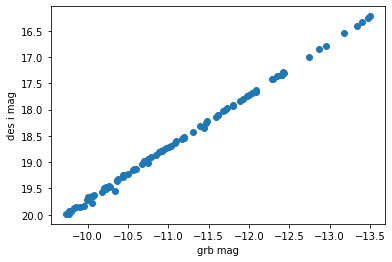

In [9]:
plt.scatter(df_grb_matched_reindex['MAG_AUTO'],df_des_matched_reindex['imag'])
plt.xlabel('grb mag')
plt.ylabel('des i mag')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [10]:
zps = df_grb_matched_reindex['MAG_AUTO']-df_des_matched_reindex['imag'] 
zp = np.nanmean(zps)
zp_err = np.nanstd(zps)
print(zp, zp_err)

-29.723476744186037 0.030556789198864714


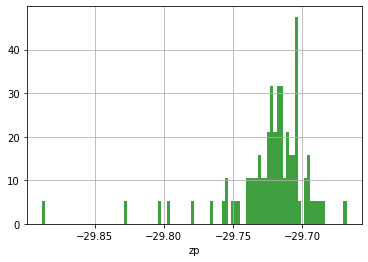

In [11]:
n, bins, patches = plt.hist(zps, 100, density=True, facecolor='g', alpha=0.75)
plt.xlabel('zp')
plt.grid(True)
plt.show()